In [1]:
%matplotlib inline
%load_ext memory_profiler

import os, sys, glob, re, math, pickle
import phate,scprep,magic,meld
import graphtools as gt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import time,random,datetime
from sklearn import metrics
from sklearn import model_selection
from scipy import sparse
from scipy.stats import mannwhitneyu, tiecorrect, rankdata
from statsmodels.stats.multitest import multipletests
import scanpy as sc
import scvelo as scv
from adjustText import adjust_text
import warnings



# settings
plt.rc('font', size = 9)
plt.rc('font', family='sans serif')
plt.rcParams['pdf.fonttype']=42
plt.rcParams['ps.fonttype']=42
plt.rcParams['text.usetex']=False
plt.rcParams['legend.frameon']=False
plt.rcParams['axes.grid']=False
plt.rcParams['legend.markerscale']=0.5
sc.set_figure_params(dpi=300,dpi_save=600,
                     frameon=False,
                     fontsize=9)
plt.rcParams['savefig.dpi']=600
sc.settings.verbosity=2
sc._settings.ScanpyConfig.n_jobs=-1
sns.set_style("ticks")


In [2]:

# fps
dfp = '/home/ngr4/project/scnd/data/'
pfp = '/home/ngr4/project/scnd/results/'
pdfp = '/home/ngr4/project/scnd/data/processed/'
sc.settings.figdir = pfp

def loader(fname,fpath,backed=None) : 
    start = time.time()
    adata = sc.read_h5ad(filename=os.path.join(fpath,fname),backed=backed)
    print('loaded @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to load data'.format(time.time()-start))
    return adata

def writer(fname,fpath,AnnData) :
    start = time.time()
    Anndata.write(os.path.join(fpath,fname))
    print('saved @'+datetime.datetime.now().strftime('%y%m%d.%H:%M:%S'))
    print('took {:.2f}-s to save data'.format(time.time()-start))
    

if False :
    # load human
    fname='hum_MT_bbknn.h5ad'
    %memit hdata = loader(fname,pdfp)
    
if True :
    # load mouse
    fname='mouse_MT_bbknn.h5ad'
    %memit mdata = loader(fname,pdfp)


loaded @200406.12:24:11
took 672.31-s to load data
peak memory: 149466.46 MiB, increment: 149263.58 MiB


## EMD heatmaps

In [3]:
def mwu(X,Y,gene_names,correction=None,debug=False) :
    '''
    Benjamini-Hochberg correction implemented. Can change to Bonferonni

    gene_names (list)
    if X,Y single gene expression array, input x.reshape(-1,1), y.reshape(-1,1)

    NOTE: get zeros sometimes because difference (p-value is so small)
    '''
    p=pd.DataFrame()
    print('starting Mann-Whitney U w/Benjamini/Hochberg correction...\n')
    start = time.time()
    for i,g in enumerate(gene_names) :
        if i==np.round(np.quantile(np.arange(len(gene_names)),0.25)) :
            print('... 25% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.5)) :
            print('... 50% completed in {:.2f}-s'.format(time.time()-start))
        elif i==np.round(np.quantile(np.arange(len(gene_names)),0.75)) :
            print('... 75% completed in {:.2f}-s'.format(time.time()-start))
        p.loc[i,'Gene']=g
        if (tiecorrect(rankdata(np.concatenate((np.asarray(X[:,i]),np.asarray(Y[:,i])))))==0) :
            if debug :
                print('P-value not calculable for {}'.format(g))
            p.loc[i,'pval']=np.nan
        else :
            _,p.loc[i,'pval']=mannwhitneyu(X[:,i],Y[:,i]) # continuity correction is True
    print('\n... mwu computed in {:.2f}-s\n'.format(time.time() - start))
    if True :
        # ignore NaNs, since can't do a comparison on these (change numbers for correction)
        p_corrected = p.loc[p['pval'].notna(),:]
        if p['pval'].isna().any():
            print('Following genes had NA p-val:')
            for gene in p['Gene'][p['pval'].isna()]:
                print('  %s' % gene)
    else : 
        p_corrected = p
    new_pvals = multipletests(p_corrected['pval'],method='fdr_bh')
    p_corrected['pval_corrected'] = new_pvals[1]
    return p_corrected

def log2aveFC(X,Y,gene_names,AnnData=None) :
    '''not sensitivity to directionality due to subtraction

    X and Y full arrays, subsetting performed here

    `gene_names` (list): reduced list of genes to calc

    `adata` (sc.AnnData): to calculate reduced list. NOTE: assumes X,Y drawn from adata.var_names
    '''
    if not AnnData is None :
        g_idx = [i for i,g in enumerate(AnnData.var_names) if g in gene_names]
        fc=pd.DataFrame({'Gene':AnnData.var_names[g_idx],
                         'log2FC':np.log2(X[:,g_idx].mean(axis=0)) - np.log2(Y[:,g_idx].mean(axis=0))}) # returns NaN if negative value 
    else :
        fc=pd.DataFrame({'Gene':gene_names,
                         'log2FC':np.log2(X.mean(axis=0)) - np.log2(Y.mean(axis=0))})
    return fc

In [4]:
# mouse 
fname = 'mouse_PC'

dge = pd.DataFrame()
for t in mdata.obs['timepoint'].unique():
    print('\nstarting timepoint {}\n'.format(t))
    start_t=time.time()
    tdata = mdata[mdata.obs['timepoint']==t,:]
    tdata=tdata[:,~tdata.var_names.isin(['Malat1'])]
    tdata.obs['value']=0
    
    cluster='ctype'
    groups = ['Purkinje cell']#tdata.obs[cluster].unique() # subset from which adata.obs var, `cluster=this var`?
    for i in groups :
        start = time.time()
        X = tdata.layers['imputed_bbknn'][(tdata.obs[cluster]==i) & (tdata.obs['genotype']=='WT') ,:]
        X_mut = tdata.layers['imputed_bbknn'][(tdata.obs[cluster]==i) & (tdata.obs['genotype']=='SCA1') ,:]

        p = mwu(X,X_mut,tdata.var_names) # directionality doesn't matter
        emd = scprep.stats.differential_expression(X_mut,X,
                                                   measure = 'emd',
                                                   direction='both', 
                                                   gene_names=tdata.var_names,
                                                   n_jobs=-1)
        emd['Gene']=emd.index
        emd=emd.drop(columns='rank')
        fc = log2aveFC(X_mut,X,tdata.var_names.to_list())
        gene_mismatch = fc['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            fc = fc.loc[gene_mismatch,:]
            warnings.warn('Warning: {} genes dropped due to p-val NA.'.format((gene_mismatch==False).sum()))
        dt = pd.merge(p,fc,how='left',on="Gene")
        gene_mismatch = emd['Gene'].isin(p['Gene'])
        if gene_mismatch.any():
            emd = emd.loc[gene_mismatch,:]
        dt = pd.merge(dt,emd,how='left',on='Gene')
        dt['Cell type']=[i]*dt.shape[0]
        dt['timepoint']=[t]*dt.shape[0]
        dt['nlog10pvalcorrected']=(-1)*np.log10(dt['pval_corrected'])
            
        dge = dge.append(dt, ignore_index=True)
        print('... computed in {:.2f}-s'.format(time.time()-start))
    print('\nFinished timepoint {} in {:.2f}-min'.format(t,(time.time()-start_t)/60))
    del tdata
if True :
    # save volcano plot data
    dge.to_csv(os.path.join(pfp,'emd_'+fname+'.csv'),index=False)



starting timepoint 5wk



Trying to set attribute `.obs` of view, making a copy.


starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 32.31-s
... 50% completed in 72.16-s
... 75% completed in 121.02-s

... mwu computed in 178.69-s

... computed in 291.36-s

Finished timepoint 5wk in 5.36-min

starting timepoint 12wk



Trying to set attribute `.obs` of view, making a copy.


starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 33.49-s
... 50% completed in 74.94-s
... 75% completed in 126.19-s

... mwu computed in 186.70-s

Following genes had NA p-val:
  Gm13398
  Fgb
  4921521D15Rik
  Gm35667
  Olfr805
  Gm28961
... computed in 192.66-s

Finished timepoint 12wk in 3.64-min

starting timepoint 18wk



Trying to set attribute `.obs` of view, making a copy.


starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 35.08-s
... 50% completed in 78.13-s
... 75% completed in 130.73-s

... mwu computed in 192.51-s

... computed in 199.26-s

Finished timepoint 18wk in 4.26-min

starting timepoint 24wk



Trying to set attribute `.obs` of view, making a copy.


starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 33.73-s
... 50% completed in 75.38-s
... 75% completed in 126.40-s

... mwu computed in 186.43-s

... computed in 192.10-s

Finished timepoint 24wk in 3.73-min

starting timepoint 30wk



Trying to set attribute `.obs` of view, making a copy.


starting Mann-Whitney U w/Benjamini/Hochberg correction...

... 25% completed in 34.26-s
... 50% completed in 76.44-s
... 75% completed in 128.01-s

... mwu computed in 188.53-s

Following genes had NA p-val:
  Gm47524
... computed in 194.52-s

Finished timepoint 30wk in 3.88-min


In [33]:
wide = dge.pivot(index='Gene',columns='timepoint',values='emd')
wide = wide[['5wk','12wk','18wk','24wk','30wk']]
wide.dropna(axis='index',inplace=True)

In [11]:
# aesthetics
cmap_timepoint = {v:sns.cubehelix_palette(8,start=.5,rot=-.75)[i+2] for i,v in enumerate(dge['timepoint'].unique())}
col_timepoint = [cmap_timepoint[i] for i in dge['timepoint']]
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}


In [44]:
wide.dropna(axis='index',inplace=True)

In [43]:
wide.loc[wide['30wk'].isna(),:]

timepoint           5wk          12wk          18wk          24wk  30wk
Gene                                                                   
Gm47524    1.299631e-10 -1.399587e-12 -2.732486e-15  1.853787e-09   NaN

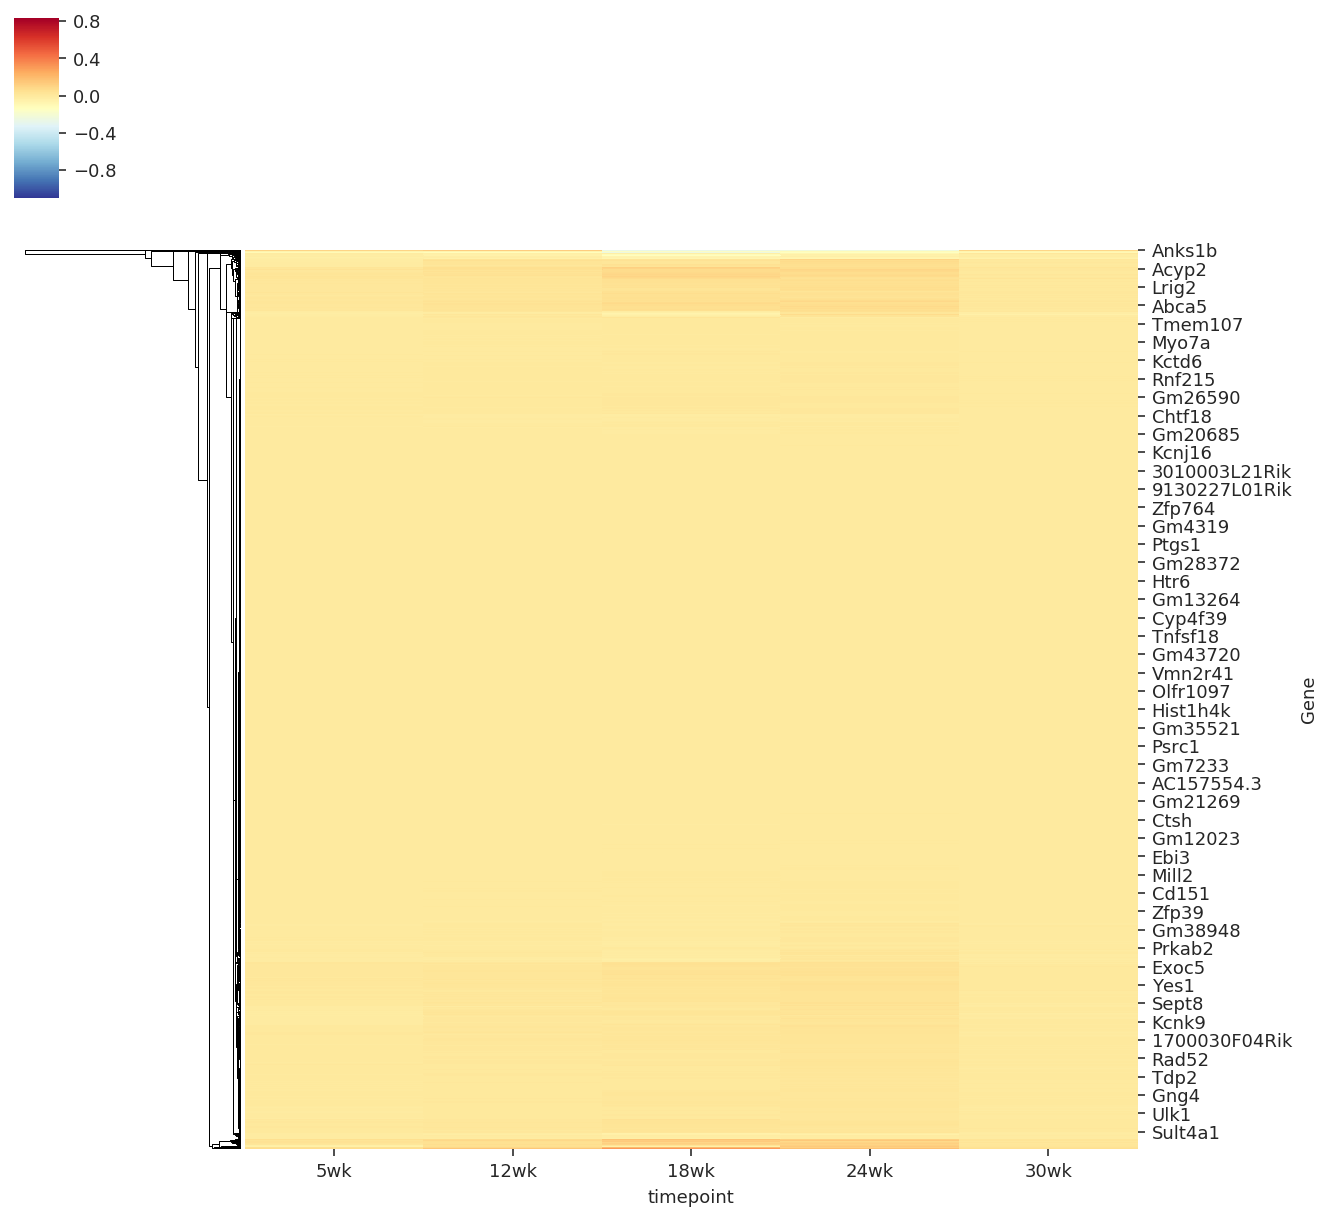

In [46]:
p = sns.clustermap(wide, 
                   cmap='RdYlBu_r',
                   row_cluster=True, col_cluster=False,
#                    row_colors=[col_timepoint],
                   z_score=None, standard_scale=None)
# p.ax_heatmap.get_xaxis
# p.ax_heatmap.set_xticklabels(['3','1','5','0','4','2'])

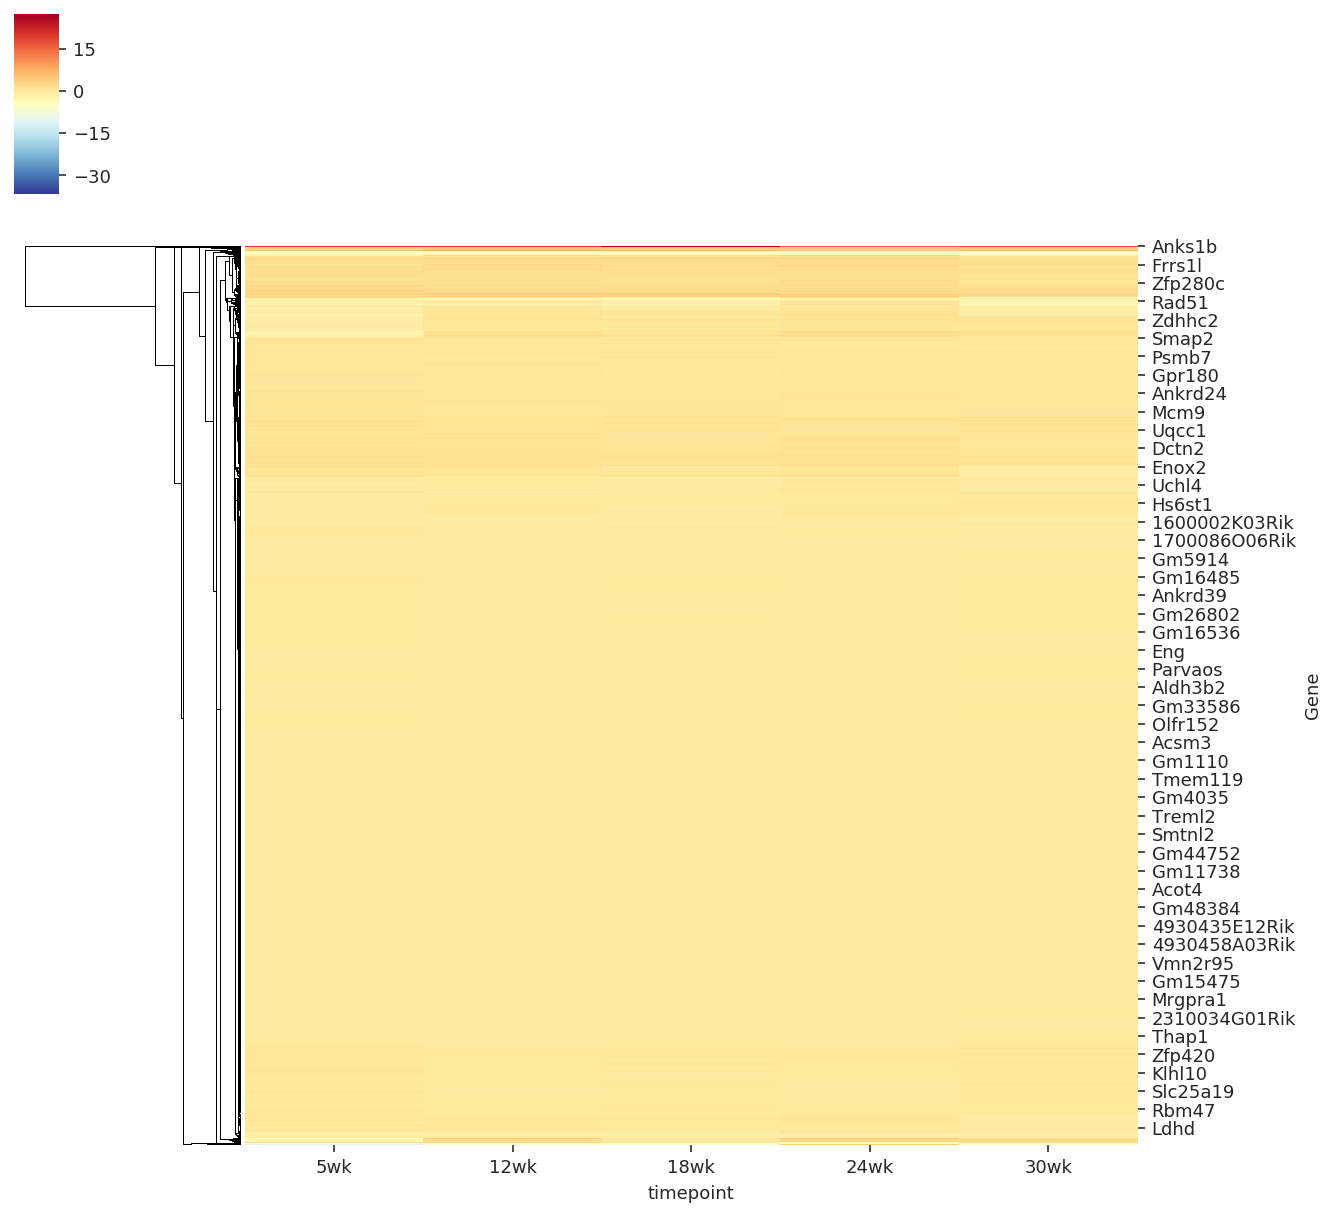

In [47]:
p = sns.clustermap(wide, 
                   cmap='RdYlBu_r',
                   row_cluster=True, col_cluster=False,
#                    row_colors=[col_timepoint],
                   z_score=1, standard_scale=None)
# p.ax_heatmap.get_xaxis
# p.ax_heatmap.set_xticklabels(['3','1','5','0','4','2'])

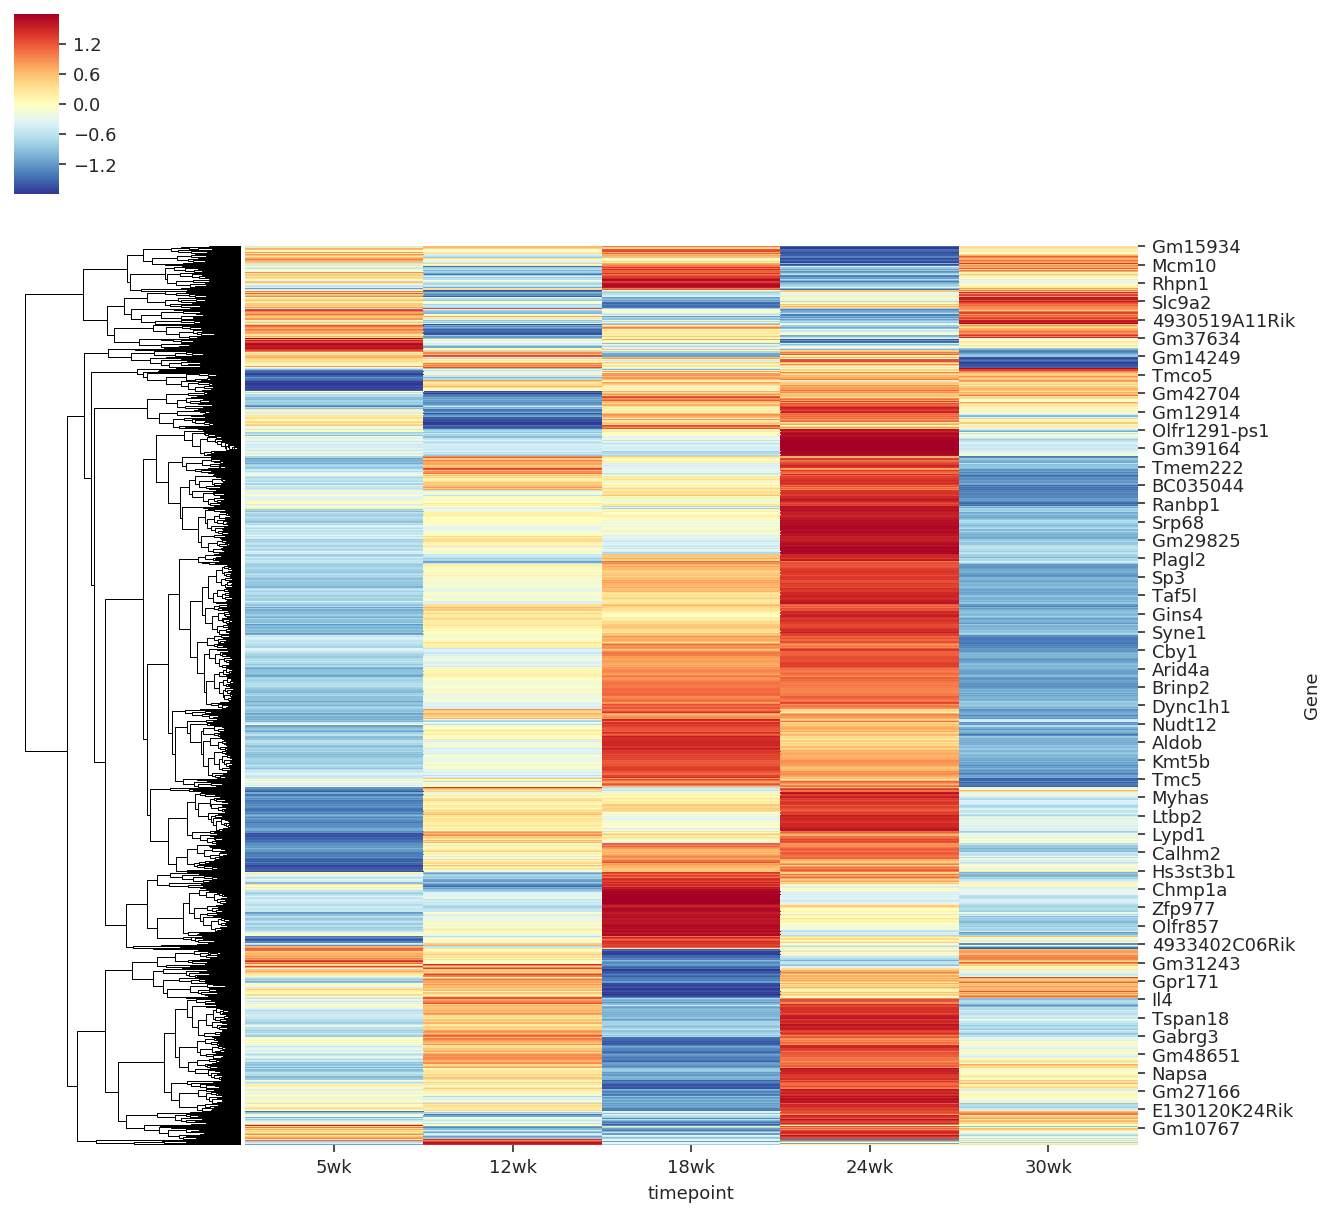

In [48]:
p = sns.clustermap(wide, 
                   cmap='RdYlBu_r',
                   row_cluster=True, col_cluster=False,
#                    row_colors=[col_timepoint],
                   z_score=0, standard_scale=None)

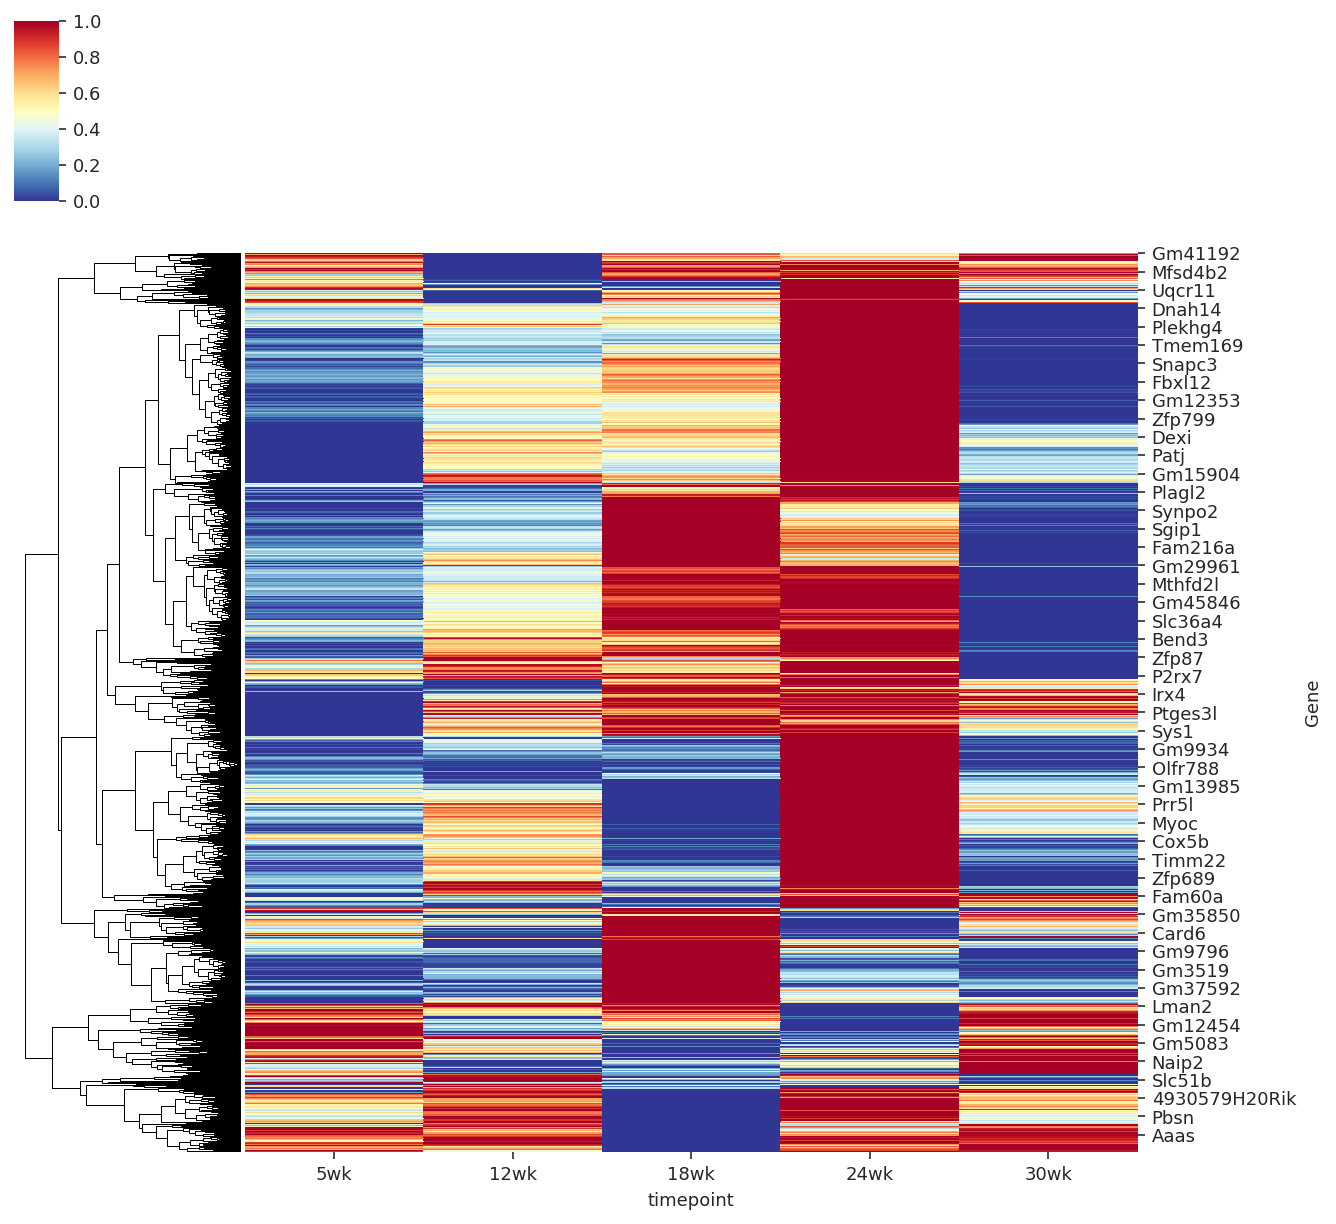

In [49]:
p = sns.clustermap(wide, 
                   cmap='RdYlBu_r',
                   row_cluster=True, col_cluster=False,
#                    row_colors=[col_timepoint],
                   z_score=None, standard_scale=0)

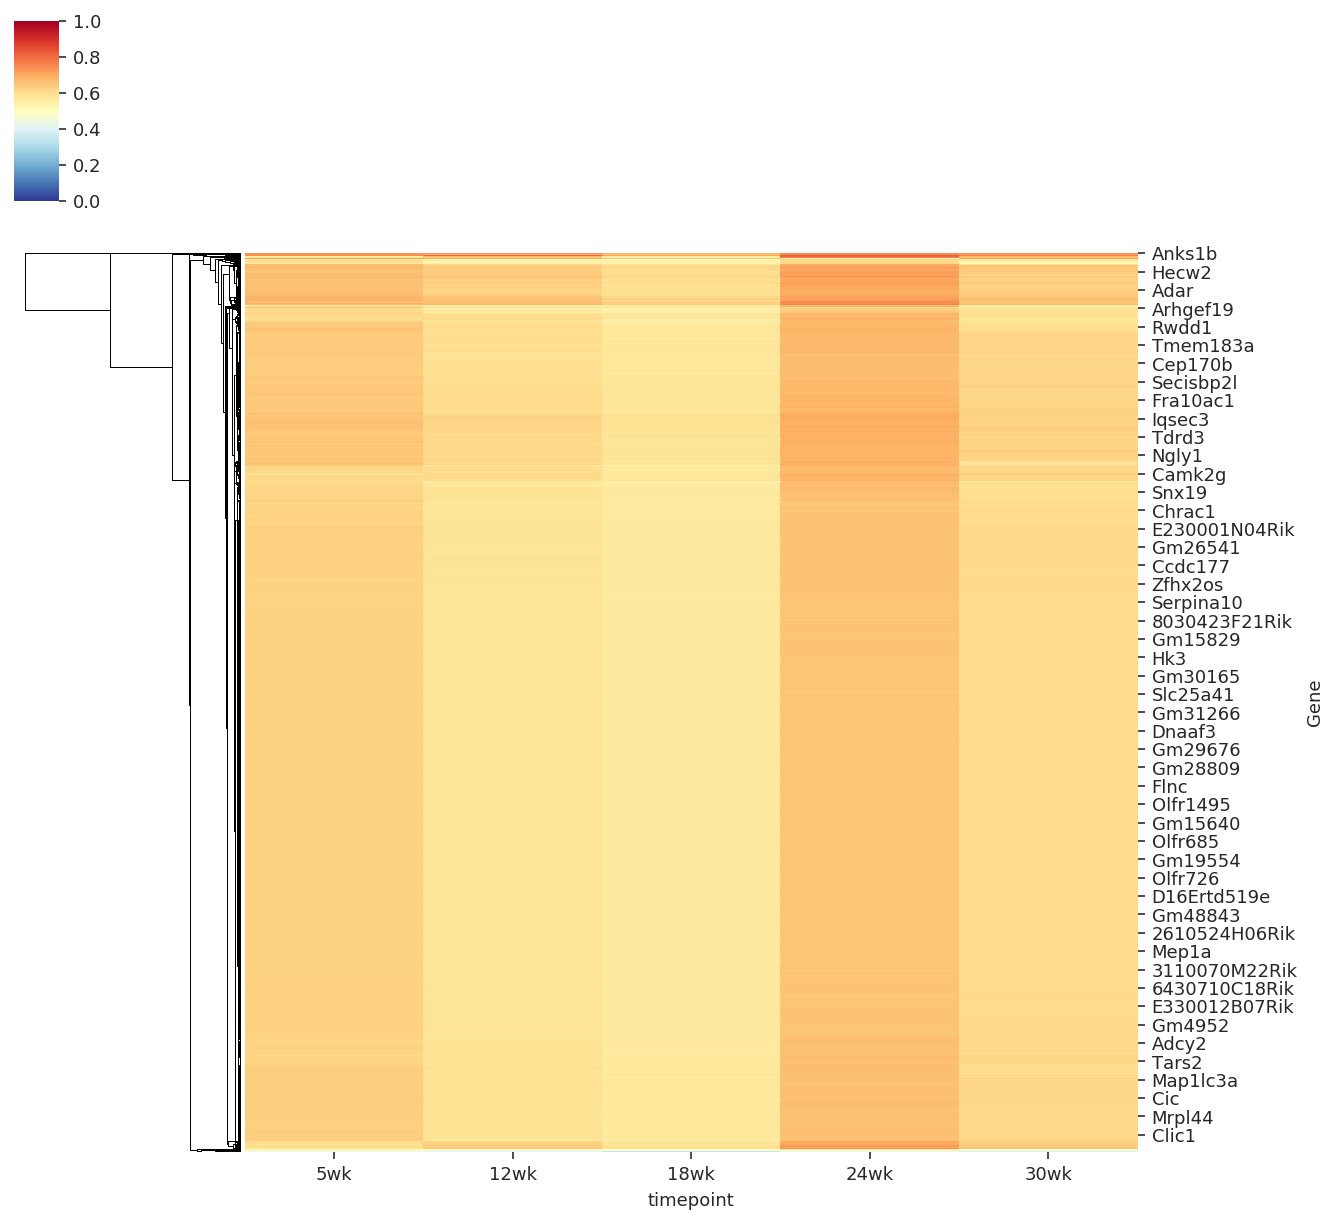

In [50]:
p = sns.clustermap(wide, 
                   cmap='RdYlBu_r',
                   row_cluster=True, col_cluster=False,
#                    row_colors=[col_timepoint],
                   z_score=None, standard_scale=1)

In [ ]:
# subset PC
X = mdata[mdata.obs['ctype']=='Purkinje cell',:]
X.obs['value']=0 # to set non copy

In [87]:
# develop
new_idx = []
for k,v in X.obs.groupby(['timepoint','genotype']).indices.items():
    new_idx += v.tolist()
X = X[new_idx,:]
X.obs['value']=0
# x = X[:,['Mbp','Mag','Mog','Calb1','Grid2','Car8']]
# x.obs['value']=0

Trying to set attribute `.obs` of view, making a copy.


In [88]:
# aesthetics
cmap_timepoint = {v:sns.cubehelix_palette(8,start=.5,rot=-.75)[i+2] for i,v in enumerate(X.obs['timepoint'].unique())}
col_timepoint = [cmap_timepoint[i] for i in X.obs['timepoint']]
cmap_genotype={'WT':'#010101',
               'SCA1':'#ffd478'}
col_genotype = [cmap_genotype[i] for i in X.obs['genotype']]

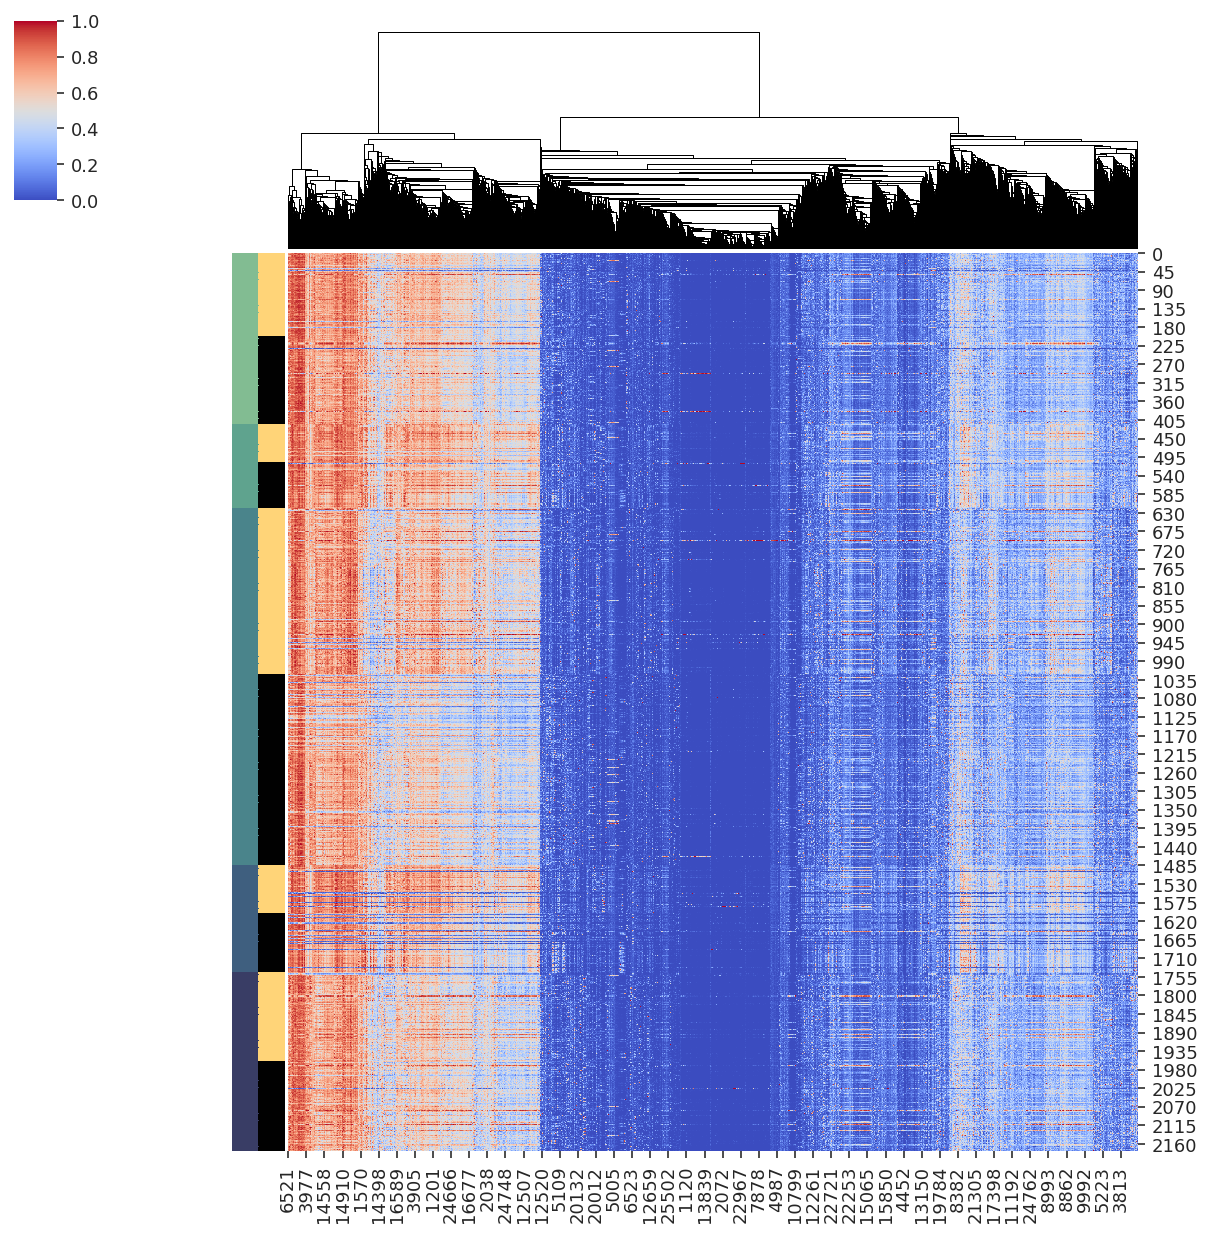

In [89]:
p = sns.clustermap(X.layers['imputed_bbknn'], cmap='coolwarm',row_cluster=False,
               row_colors=[col_timepoint,col_genotype],
               z_score=None, standard_scale=1)
# p.ax_heatmap.get_xaxis
# p.ax_heatmap.set_xticklabels(['3','1','5','0','4','2'])

In [82]:
p.ax_heatmap.set_xticklabels(['3','5','4','0','1','2'])

[Text(0.5, 0, '3'),
 Text(1.5, 0, '5'),
 Text(2.5, 0, '4'),
 Text(3.5, 0, '0'),
 Text(4.5, 0, '1'),
 Text(5.5, 0, '2')]

In [ ]:
sns.clustermap(x.layers['imputed_bbknn'], cmap='coolwarm',row_cluster=False,
               row_colors=[col_timepoint,col_genotype],
               z_score=1, standard_scale=None)

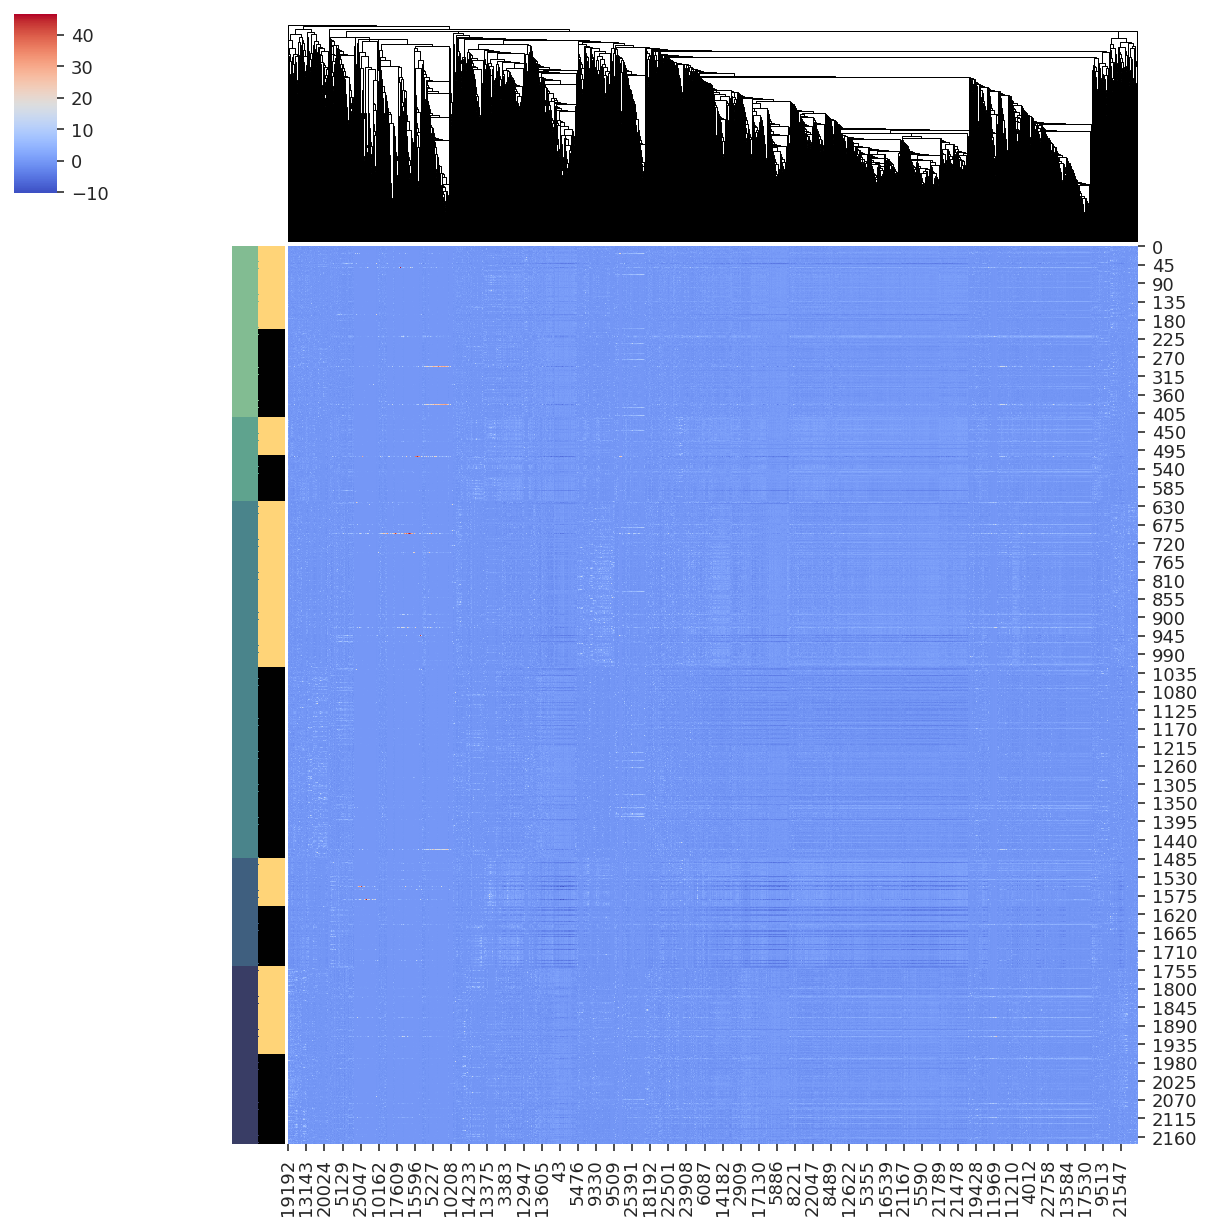

In [90]:
sns.clustermap(X.layers['imputed_bbknn'], cmap='coolwarm',row_cluster=False,
               row_colors=[col_timepoint,col_genotype],
               z_score=1, standard_scale=None)
# plt.setp(g.ax_heatmap.get_yticklabels(), rotation=0)  # For y axis


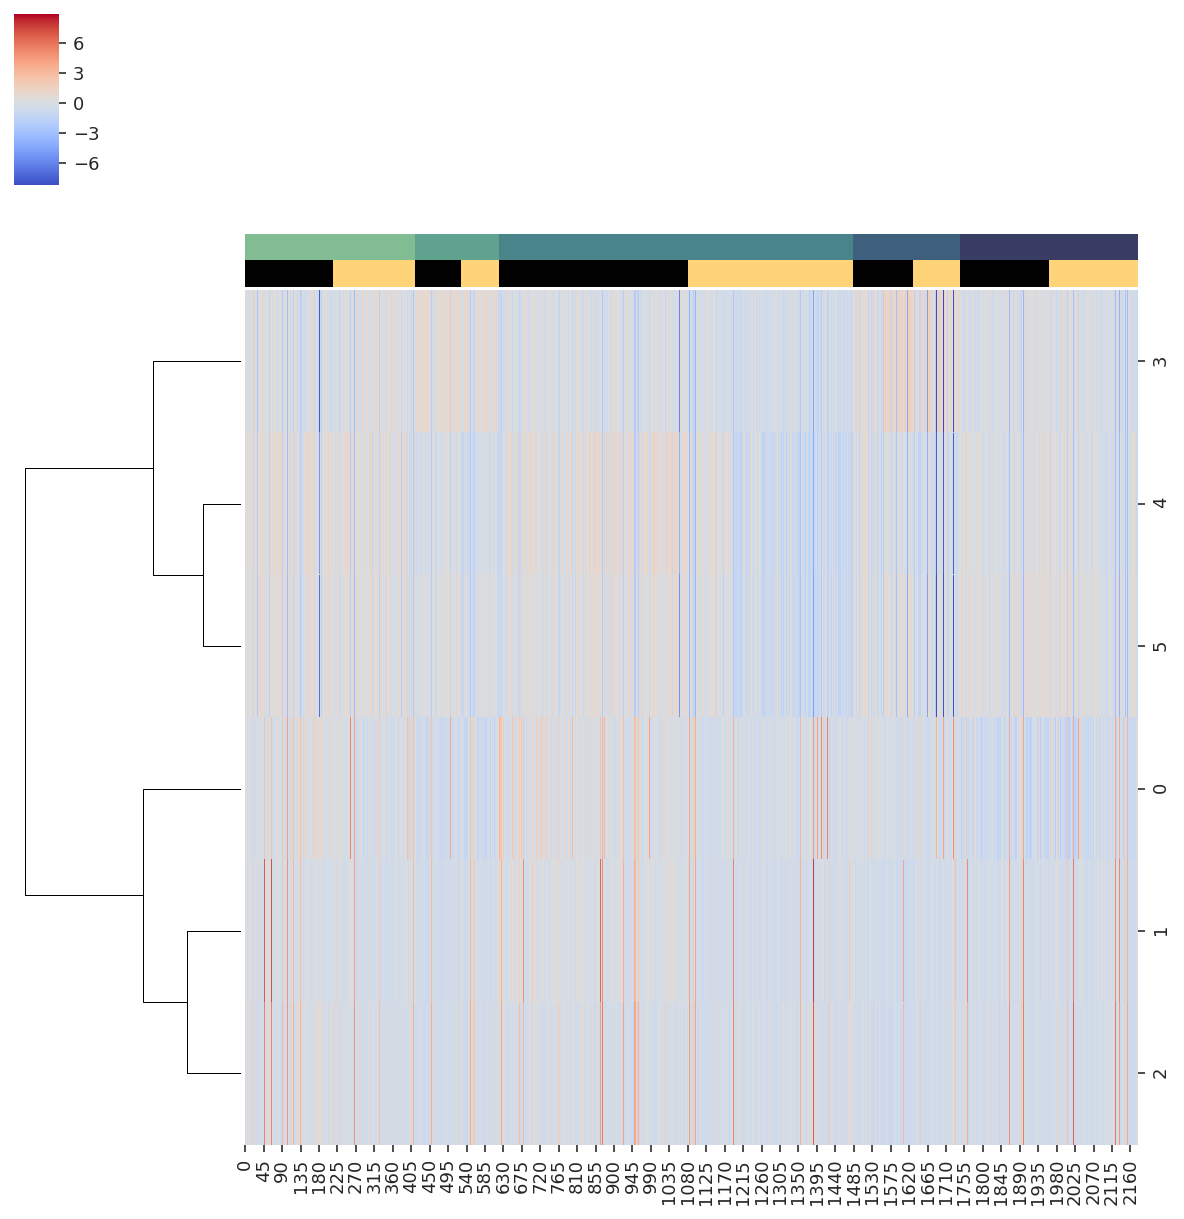

In [75]:
sns.clustermap(x.layers['imputed_bbknn'].T, cmap='coolwarm',col_cluster=False,
               col_colors=[col_timepoint,col_genotype],
               z_score=0, standard_scale=None)

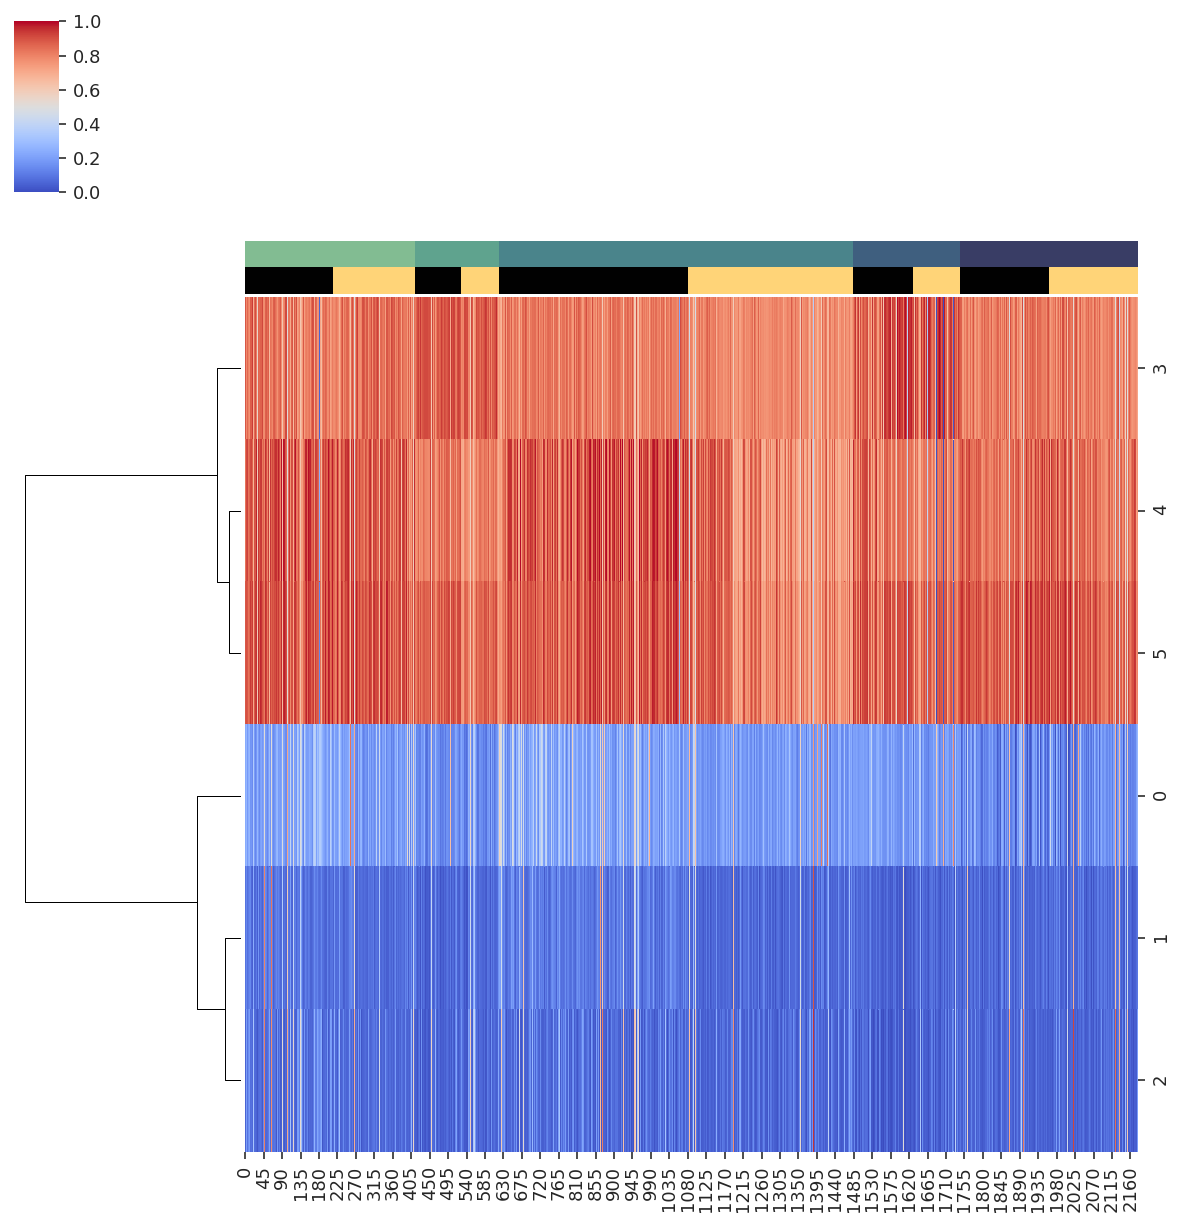

In [72]:
sns.clustermap(x.layers['imputed_bbknn'].T, cmap='coolwarm',col_cluster=False,
               col_colors=[col_timepoint,col_genotype],
               z_score=None, standard_scale=0)